#P4   Modelado de la Turbidez como Serie Temporal

*Instalación* de paquetes y librerías. Respétese el orden para no tener incompatibilidades.



In [ ]:
!pip install pmdarima

In [ ]:
!pip install prophet

In [ ]:
from pmdarima.arima import auto_arima 

In [ ]:
from fbprophet import Prophet

# P4.1  Chequeo de Índices Temporales

In [ ]:
import pandas as pd
import math
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

path='turbitidy_cycle17_21.csv'

from statsmodels.tsa.seasonal import seasonal_decompose
# holt winters 
# (SES) single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# (DTE) double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Esta es la función con la que calcularemos los errores. Tenemos básicamente tres grupos de estimadores de error, los basados en la mediana, los basados en la media y los porcentuales. Los basados en la media aritmética son útiles a la hora de determinar el comportamiento de la predicción teniendo en cuenta factores externos generados como picos de turbidez. Los basados en la mediana, son más robustos y evitan los outliers. Finalmente los porcentuales miden la desviación porcentual de la señal real respecto a la predicha, siendo los que más vamos a utilizar. Especialmente SMAPE.

In [ ]:
def calculate_error(y_pred,y_test, print_message=True):
#Imprime los resultados del 
#y_pred: tipo 1D array o asimilado, valores prededecidos
#y_test: tipo 1D array o asimilado, valores reaales
#print_message :imprime los errores calculado por pantalla.


  # # Mean Absolute Error (MAE)
  MAE = np.mean(abs(y_pred - y_test))
  
  # Median Absolute Error (MedAE)
  MEDAE = np.median(abs(y_pred - y_test))


  # Mean Squared Error (MSE)
  MSE = np.square(np.subtract(y_pred, y_test)).mean()
 

  # Root Mean Squarred Error (RMSE) 
  RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
  

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100

  def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

  if (print_message) :
      print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))
      print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))
      print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))
      print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))
      print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')
      print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

  return MAE,MEDAE,MSE,RMSE,MAPE,MDAPE

In [ ]:
def calculate_error_smape(y_test, y_pred):
    #No usar si algún resultado de un forecast puede ser cero.
    return 1/len(y_test) * np.sum(2 * np.abs(y_pred-y_test) / (np.abs(y_test) + np.abs(y_pred))*100)

In [ ]:
df_turbidity_source = pd.read_csv(path, delimiter=',',infer_datetime_format=True, index_col='datetime',parse_dates=True)
df_turbidity_source['116507_63680']=pd.to_numeric(df_turbidity_source['116507_63680'])


In [ ]:
df_turbidity= df_turbidity_source.copy()

Comprobar siempre cómo han sido interpretados los campos, especialmente los numéricos y las fechas, que no aparezcan como tipos cadena.

In [ ]:
df_turbidity_source.dtypes

agency_cd           object
site_no              int64
tz_cd               object
116507_63680       float64
116507_63680_cd     object
dtype: object

Comprobación de Indices: 

In [ ]:
fixed_time_index = pd.date_range(start ='2017-05-31 00:00:00' , end = '2021-03-18 03:45:00',freq='15T')
difference_index= fixed_time_index.difference(df_turbidity_source.index)

Si *difference_index* no está vacío, entonces las fechas del dataset serán compactas y no habrá huecos de tiempo. En caso contrario muchos métodos no podrán ajustar la periodicidad. En este caso bien:

In [ ]:
difference_index

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Comprobación de Missing Values:

In [ ]:
print("Missings Detectados : ")
print(df_turbidity_source.isnull().sum())

Missings Detectados : 
agency_cd          0
site_no            0
tz_cd              0
116507_63680       0
116507_63680_cd    0
dtype: int64


Mostramos el Gráfico. Vemos que existe una determinada estacionalidad en torno a enero, sin embargo los modelos no la detectan, especialmente los autoregresivos. Puede ser que no se hayan configurado suficientes pasos autoregresivos para estudiar o que para detectar la estacionalidad necesiten disminuir el tiempo de muestra. El problema del tiempo de muestra es que si se disminuye para poder detectar la estacionalidad, no tendremos suficiente resolulción para detectar eventos como la subida brusca de turbidez en horas.

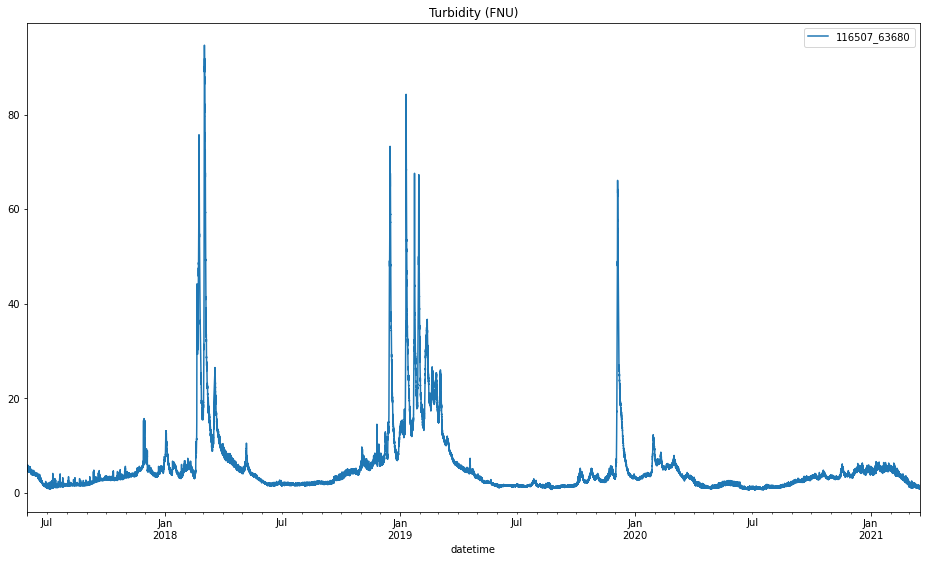

In [ ]:
df_turbidity[['116507_63680']].plot(title='Turbidity (FNU)',figsize=(16,9))

In [ ]:
ts=df_turbidity.drop(['agency_cd','site_no','tz_cd','116507_63680_cd'],axis=1)

In [ ]:
ts=ts.squeeze()

Comprobar que se ha generado una pd.Series, y que se asigna sin errores la frequencia de 15 minutos "15T" al indice.

In [ ]:
type(ts)

pandas.core.series.Series

Si al hacer esto no hay problemas, entonces los índices de tiempo están bien.

In [ ]:
ts.index.freq="15T"

In [ ]:
print(ts)

datetime
2017-05-31 00:00:00    5.2
2017-05-31 00:15:00    5.2
2017-05-31 00:30:00    5.2
2017-05-31 00:45:00    5.2
2017-05-31 01:00:00    5.3
                      ... 
2021-03-18 02:45:00    0.9
2021-03-18 03:00:00    0.9
2021-03-18 03:15:00    1.0
2021-03-18 03:30:00    0.9
2021-03-18 03:45:00    0.9
Freq: 15T, Name: 116507_63680, Length: 133168, dtype: float64


# P4.2  Estudio de Descomposición de la Serie Temporal

Realizamos la descomposición:

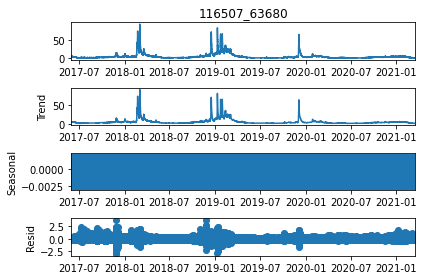

In [ ]:


with warnings.catch_warnings():
    # eliminar avisos en este bloque
    warnings.simplefilter("ignore")

    #descomposción aditiva
    decompose_result = seasonal_decompose(ts, model='aditive', freq=12)
    decompose_result.plot();



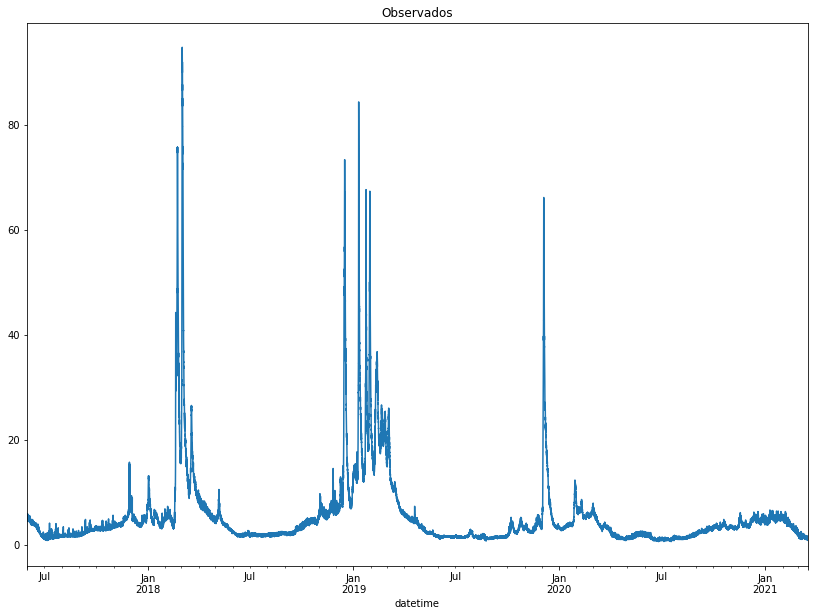

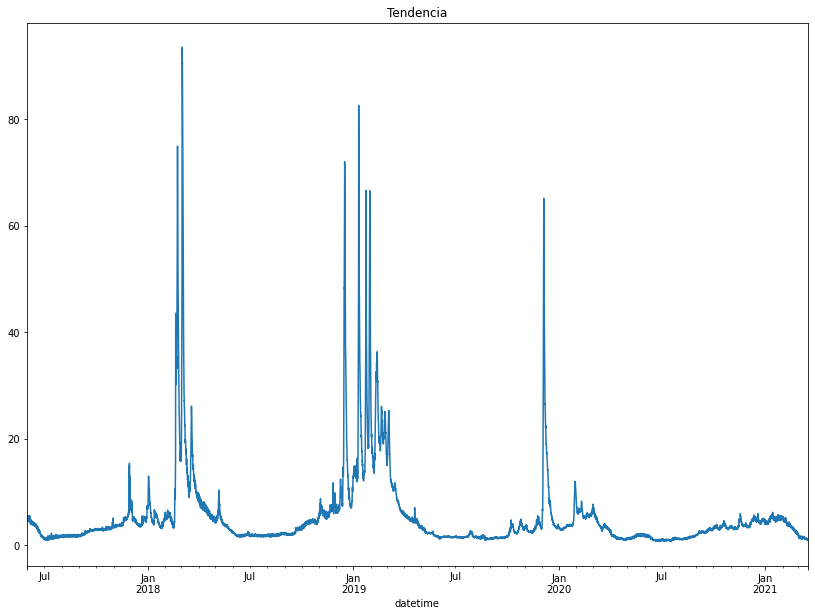

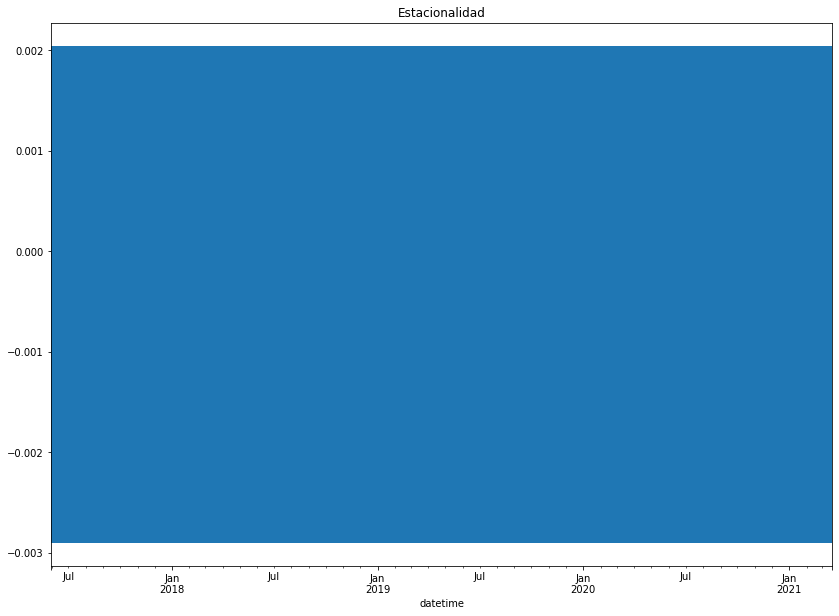

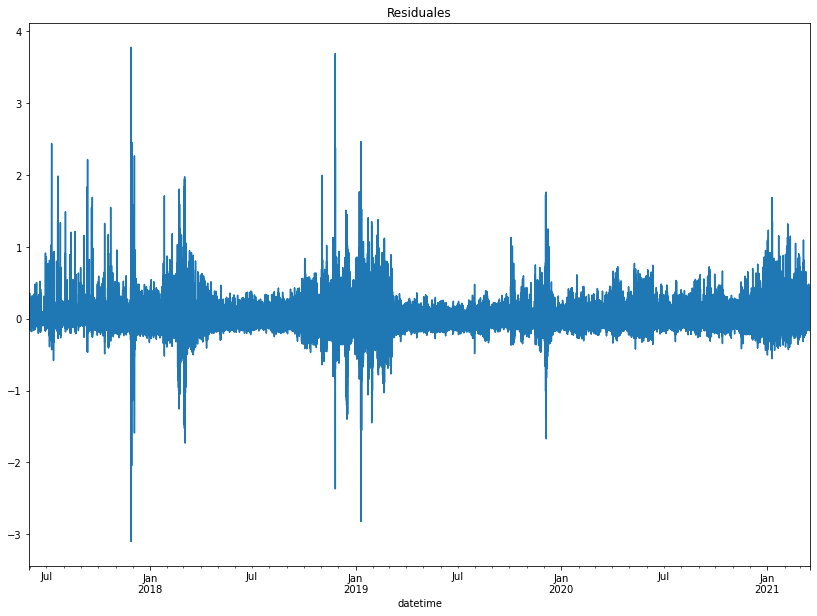

In [ ]:
plt.figure(figsize=(14,10))
decompose_result.observed.plot()
plt.xticks(rotation=0)
plt.title('Observados')
plt.show()

plt.figure(figsize=(14,10))
decompose_result.trend.plot()
plt.xticks(rotation=0)
plt.title('Tendencia')
plt.show()

plt.figure(figsize=(14,10))
decompose_result.seasonal.plot()
plt.xticks(rotation=0)
plt.title('Estacionalidad')
plt.show()


plt.figure(figsize=(14,10))
decompose_result.resid.plot()
plt.xticks(rotation=0)
plt.title('Residuales')
plt.show()

Vamos a realizar dos pruebas KPSS y ADF. Ambas testean la estacionalidad de la serie, sin embargo KPSS es un poco más flexible y testea la si existe estacionalidad "determinista". En todos los casos vemos que la serie no es estacional.

Una diferencia importante entre las pruebas KPSS y ADF es la capacidad de la prueba KPSS para comprobar la estacionariedad en "presencia de una tendencia determinista". Prueba KPSS: comprueba la estacionariedad de la serie en torno a una "tendencia determinista".

Lo que esto significa para nosotros es que la prueba no tiene por qué rechazar la hipótesis nula (que la serie es estacionaria) aunque la serie aumente o disminuya de forma constante.

La palabra "determinista" implica que la pendiente de la tendencia de la serie no cambia permanentemente. Es decir, aunque la serie pase por un shock, tiende a recuperar su trayectoria original.

Si una serie es estacionaria según la prueba KPSS estableciendo regresión='ct' y no es estacionaria según la prueba ADF, significa que la serie es estacionaria en torno a una tendencia determinista y, por tanto, es bastante fácil modelar esta serie y producir previsiones bastante precisas. 

In [ ]:
#Fuente: https://www.machinelearningplus.com/kpss-test-for-stationarity/

def kpss_test(series, **kw): 
   
    from statsmodels.tsa.stattools import kpss 
   
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Resultado: La serie es  {"no " if p_value < 0.05 else ""}estacionaria.')
    print("___________________________________________________")


In [ ]:
#Fuente: Basado en el trabajo https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/

def ADF_Stationarity_Test(timeseries, printResults = True):
        
        from statsmodels.tsa.stattools import adfuller
        
        SignificanceLevel=0.05     
        adfTest = adfuller(timeseries, autolag='AIC')
        
        pValue = adfTest[1]
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
        

Comprobamos que la serie no es estacionaria H0: p<0.05 se rechaza que la serie sea estacionaria:

In [ ]:
ADF_Stationarity_Test(ts)
        

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.040792e+01
P-Value                 1.836109e-18
# Lags Used             6.800000e+01
# Observations Used     1.330990e+05
Critical Value (1%)    -3.430399e+00
Critical Value (5%)    -2.861562e+00
Critical Value (10%)   -2.566782e+00
dtype: float64


In [ ]:
print("Prueba KPSS para Estacionariedad ")
kpss_test(ts,nlags="legacy")

Prueba KPSS para Estacionalidad 
KPSS Statistic: 7.762327839131263
p-value: 0.01
num lags: 73
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Resultado: La serie es  no estacionaria.
___________________________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




El parámetro regression='ct' testea la estacionariedad en la tendencia determinista

In [ ]:
print("Prueba KPSS para Estacionariedad Determinista")
kpss_test(ts,nlags="legacy",  regression='ct')

Prueba KPSS para Estacionalidad Determinista
KPSS Statistic: 3.672680718236145
p-value: 0.01
num lags: 73
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es  no estacionaria.
___________________________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Ahora miramos los residuos, si los residuos son estacionarios ya no podrían modelarse buscando autocorrelación y por tanto la descomposición ya está concluída.

In [ ]:
print("Test sobre residuo :")
kpss_test(decompose_result.resid.dropna(),nlags="legacy",  regression='ct')

KPSS Statistic: 0.00030985809779170473
p-value: 0.1
num lags: 73
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es  estacionaria.
___________________________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




# P4.3 Definición Datasets Para Entrenamiento

Ees importante igualar el cjto de entrenamiento / test a a las proporciones 80/20%, si bien el mantenimiento de las geometrías representativas es también importante.


Cjto Entrenamiento % : 85.44672111105677
Cjto Test % : 14.55816910362365


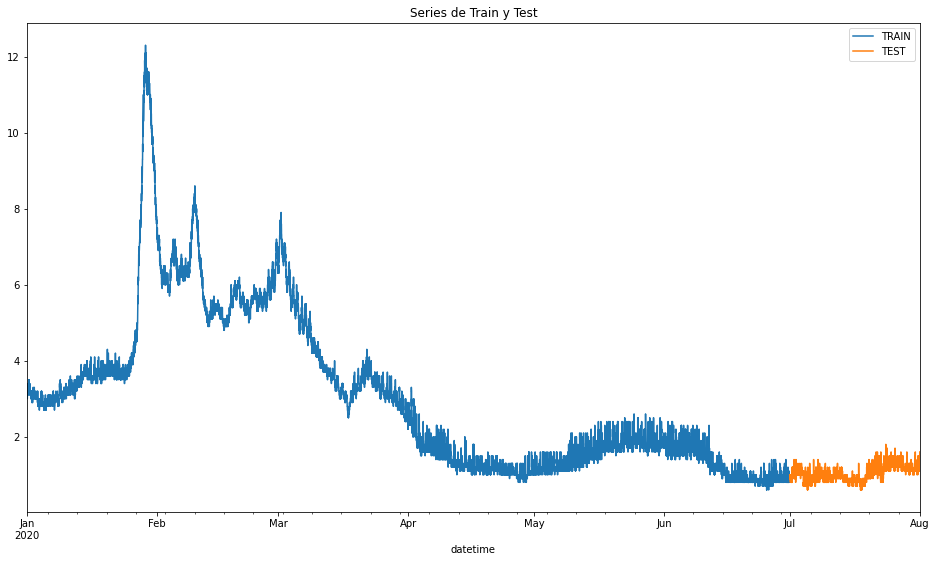

In [ ]:
# Split into train and test set

UpperBound = '2020-08-01 0:00:00'
LowerBound = '2020-01-01 0:00:00'
TestBound = '2020-07-01 0:00:00'



df_range = pd.DataFrame()
train_turbidity= pd.DataFrame()
test_turbidity= pd.DataFrame()

df_range['116507_63680']=df_turbidity['116507_63680'][LowerBound:UpperBound]

train_turbidity['116507_63680']=df_range['116507_63680'][:TestBound]
test_turbidity['116507_63680']=df_range['116507_63680'][TestBound:]

train_turbidity['116507_63680'].plot(legend=True,label='TRAIN',figsize=(16,9))
test_turbidity['116507_63680'].plot(legend=True,label='TEST',figsize=(16,9))

train_turbidity.index.freq="15T"
test_turbidity.index.freq="15T"

plt.title('Series de Train y Test')

print("Cjto Entrenamiento % :",(train_turbidity.shape[0]/df_range.shape[0])*100)
print("Cjto Test % :",(test_turbidity.shape[0]/df_range.shape[0])*100)

## P4.4  Evaluación de Resultados

In [ ]:
def marshall_results(predictions,test):


  df_results =pd.DataFrame(predictions)
  df_results.reset_index(inplace=True)
  df_results.columns=['ds','y_hat']
  low=df_results['ds'][0]
  high=df_results['ds'][df_results.shape[0]-1]
  df_results['y']=test['116507_63680'][str(low):str(high)].values

  y= df_results['y'].values
  y_hat = df_results['y_hat'].values

  return y_hat, y

In [ ]:
def marshall_results_ARIMA(steps_fordward,test):
  
  workingcopy=pd.DataFrame() 
  workingcopy=test.copy()

  workingcopy.reset_index(inplace=True)

  low = workingcopy['datetime'][0]
  high =workingcopy['datetime'][steps_fordward-1]
  df_results=pd.DataFrame()
  df_results['y']=test['116507_63680'][str(low):str(high)].values

  y = df_results['y'].values

  return y

In [ ]:
def marshall_results_Prophet(predictions,test):
 
  data_prediction= predictions.copy()
  data_prediction['ds']= pd.to_datetime(data_prediction['ds'])
  data_prediction.index =data_prediction['ds'] 
  
  low=data_prediction['ds'][0]
  high=data_prediction['ds'][data_prediction.shape[0]-1]
  
  y= test['116507_63680'][str(low):str(high)].values
  y_hat = data_prediction[TestBound:]['yhat'].values

  return y_hat, y

Los modelos Holt Winters se usa el modelo aditivo (trend='add') ya que el multiplicativo se usa cuando la serie tiene una tendencia, al menos localmente, y un patrón estacionalmente creciente. Que claramente no es el caso. En general, SimpleExpSmoothing puede ser usado  cuando tiene tendencia, pero no será muy adecuado si tiene un componente estacional. Por el contrario el Exponencia Smoothing es el filtro completo y proporciona nivel, tendencia y estacionalidad. Como se verá, el hecho de que SES tenga mejores ratios, implica que que la serie sólo tienen tendencia, cosa que ya hemos confirmado. 

A continuación entrenamos los modelos:

In [ ]:
m = 0.4
alpha = 1/(2*m)

fitted_SES=SimpleExpSmoothing(train_turbidity['116507_63680']).fit(smoothing_level=alpha,optimized=False,use_brute=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [ ]:
fitted_model = ExponentialSmoothing(train_turbidity['116507_63680'],trend='add').fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



En el modelo prophet(), el intervalo de confianza se establece en el entrenamiento con interval_width=0.95

In [ ]:
prophet_train_dataset = train_turbidity.copy()
prophet_train_dataset.reset_index(inplace=True)

prophet_train_dataset.columns = ['ds','y']
prophet_predictor=Prophet(interval_width=0.95)
prophet_predictor.fit(prophet_train_dataset)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
import pickle
#Si en vez de cargar el modelo se quiere entrenar entonces
#habilite las líneas de código:

model_auto=auto_arima(train_turbidity['116507_63680'])

with open('arima.pkl', 'wb') as pkl:
  pickle.dump(model_auto, pkl)


#Si en vez de cargar el modelo se quiere entrenar entonces
# INhabilite las líneas de código:
#with open('arima.pkl', 'rb') as pkl:
#    model_auto = pickle.load(pkl)

In [ ]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17473
Model:               SARIMAX(1, 1, 2)   Log Likelihood               12907.895
Date:                Sun, 20 Jun 2021   AIC                         -25807.791
Time:                        14:28:41   BIC                         -25776.717
Sample:                             0   HQIC                        -25797.557
                              - 17473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4323      0.060      7.183      0.000       0.314       0.550
ma.L1         -0.9715      0.061    -15.848      0.000      -1.092      -0.851
ma.L2          0.1799      0.037      4.812      0.000       0.107       0.253
sigma2         0.0134   6.92e-05    193.008      0.000       0.013       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             37520.49
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Definimos aquí los puntos donde comprobaremos los errores. Recordemos que 1H son 4 steps

In [ ]:
forecast_steps_dict = {
  "1H": 4,
  "3H": 12,
  "6H": 24,
  "12H": 48,
  "1D": 96,
  "2D": 192,
  "5D": 480,
  "7D": 672,
  "15D": 1440
}

In [ ]:
models = list()
models.append(fitted_SES)
models.append(fitted_model)
models.append(model_auto)
models.append(prophet_predictor)


In [ ]:
df_results= pd.DataFrame()
#df_results.columns = ["Estimator","Horizon_Prediction","MAE","MEDAE","MSE","RMSE","MAPE","MDAPE"]



In [ ]:
for current_model in models:

  steps = forecast_steps_dict.keys()
  
  type_str=str(current_model)

  print("                                                              ")
  print("**************************************************************")
   

  for t in steps:
    
        forecast_steps_iter=forecast_steps_dict[t]

        print(" -> "+str(t))
       
        str_model = str(type(current_model))

        if (str_model=="<class 'pmdarima.arima.arima.ARIMA'>"):
         # print(current_model.summary())
          id_model=" AUTOARIMA   Confidence Interval 0.95"
          print(id_model)
          y_forec  = current_model.predict(forecast_steps_iter,alpha=0.05)
          y=marshall_results_ARIMA(forecast_steps_iter,test_turbidity)
          MAE,MEDAE,MSE,RMSE,MAPE,MDAPE = calculate_error(y_forec,y)
          SMAPE = calculate_error_smape(y_forec,y)

        elif (str_model =="<class 'fbprophet.forecaster.Prophet'>"):
          #print(" Prophet : Confidence Interval 0.95 ")
          id_model = " Prophet : Confidence Interval 0.95 "
          print(id_model)
          future = current_model.make_future_dataframe(periods=forecast_steps_iter,freq='15min')
          forecast=current_model.predict(future)
          yhat,y_test = marshall_results_Prophet(forecast,test_turbidity)
          MAE,MEDAE,MSE,RMSE,MAPE,MDAPE = calculate_error(yhat,y_test)
          SMAPE = calculate_error_smape(yhat,y_test)

        else:
          #print(str(type(current_model)))
          id_model = " Holt-Winters : Confidence Interval 0.95 "
          print(id_model)
          y_pred = current_model.forecast(forecast_steps_iter)
          yhat,y_test = marshall_results(y_pred,test_turbidity)
          MAE,MEDAE,MSE,RMSE,MAPE,MDAPE = calculate_error(yhat,y_test)
          SMAPE = calculate_error_smape(yhat,y_test)

          

        new_row = {'Estimator':id_model, 'Horizon_Prediction':str(t), 'MAE':MAE, 'MEDAE':MEDAE, 'MSE':MSE, 'RMSE':RMSE, 'MAPE':MAPE, 'MDAPE':MDAPE, 'SMAPE':SMAPE}
        df_results = df_results.append(new_row, ignore_index=True)
        

                                                              
**************************************************************
 -> 1H
 Holt-Winters : Confidence Interval 0.95 
Mean Absolute Error (MAE): 0.05
Median Absolute Error (MedAE): 0.05
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.07
Mean Absolute Percentage Error (MAPE): 5.05 %
Median Absolute Percentage Error (MDAPE): 5.05 %
 -> 3H
 Holt-Winters : Confidence Interval 0.95 
Mean Absolute Error (MAE): 0.04
Median Absolute Error (MedAE): 0.01
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.06
Mean Absolute Percentage Error (MAPE): 4.36 %
Median Absolute Percentage Error (MDAPE): 0.92 %
 -> 6H
 Holt-Winters : Confidence Interval 0.95 
Mean Absolute Error (MAE): 0.04
Median Absolute Error (MedAE): 0.01
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.06
Mean Absolute Percentage Error (MAPE): 4.38 %
Median Absolute Percentage Error (MDAPE): 0.92 %
 -> 12H
 Holt-Winters : Confidence In

In [ ]:
#df_results= pd.read_csv('results.csv', delimiter=',')
df_results.to_csv('results.csv')


In [ ]:
df_results.to_csv('results.csv')

In [ ]:
df_results_1H = df_results[df_results['Horizon_Prediction']=="1H"]
df_results_3H = df_results[df_results['Horizon_Prediction']=="3H"]
df_results_6H = df_results[df_results['Horizon_Prediction']=="6H"]
df_results_12H = df_results[df_results['Horizon_Prediction']=="12H"]
df_results_1D = df_results[df_results['Horizon_Prediction']=="1D"]
df_results_2D = df_results[df_results['Horizon_Prediction']=="2D"]
df_results_5D = df_results[df_results['Horizon_Prediction']=="5D"]
df_results_7D = df_results[df_results['Horizon_Prediction']=="7D"]
df_results_15D = df_results[df_results['Horizon_Prediction']=="15D"]
df_Arima= df_results[df_results['Estimator']=="AUTOARIMA Confidence Interval 0.95	"]

In [ ]:
df_results_1H

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
0,Holt-Winters : Confidence Interval 0.95,1H,0.050000,5.046117,5.046117,0.050000,0.004239,0.065106,5.264319
9,Holt-Winters : Confidence Interval 0.95,1H,0.050000,5.099850,5.107354,0.050064,0.003526,0.059378,5.265382
18,AUTOARIMA Confidence Interval 0.95,1H,0.049086,4.994981,5.036173,0.049448,0.003534,0.059449,5.165546
27,Prophet : Confidence Interval 0.95,1H,0.210093,22.139149,19.196250,0.172766,0.046618,0.215913,25.013151


In [ ]:
df_results_3H

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
1,Holt-Winters : Confidence Interval 0.95,3H,0.043050,4.358822,0.922345,0.008301,0.003544,0.059530,4.539951
10,Holt-Winters : Confidence Interval 0.95,3H,0.044480,4.560612,1.996998,0.017973,0.003007,0.054837,4.697469
19,AUTOARIMA Confidence Interval 0.95,3H,0.038958,4.023419,1.978012,0.017802,0.002463,0.049630,4.129375
28,Prophet : Confidence Interval 0.95,3H,0.210469,22.222290,19.326445,0.173938,0.046682,0.216061,25.112757


In [ ]:
df_results_6H

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
2,Holt-Winters : Confidence Interval 0.95,6H,0.040959,4.379153,0.922345,0.008301,0.003473,0.058932,4.433506
11,Holt-Winters : Confidence Interval 0.95,6H,0.044222,4.778949,1.925527,0.017330,0.003297,0.057419,4.791510
20,AUTOARIMA Confidence Interval 0.95,6H,0.040597,4.312108,1.978144,0.017803,0.002760,0.052536,4.360589
29,Prophet : Confidence Interval 0.95,6H,0.189505,20.288408,19.136668,0.172230,0.039228,0.198060,22.754783


In [ ]:
df_results_12H

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
3,Holt-Winters : Confidence Interval 0.95,12H,0.053459,5.956065,5.046117,0.050000,0.004931,0.070218,5.903666
12,Holt-Winters : Confidence Interval 0.95,12H,0.056031,6.280590,5.107354,0.050064,0.004884,0.069883,6.185771
21,AUTOARIMA Confidence Interval 0.95,12H,0.055257,6.179893,1.978144,0.017803,0.004738,0.068831,6.083571
30,Prophet : Confidence Interval 0.95,12H,0.168782,18.062662,18.545317,0.166908,0.033962,0.184289,20.172248


In [ ]:
df_results_1D

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
4,Holt-Winters : Confidence Interval 0.95,1D,0.084379,8.397640,9.169889,0.091699,0.012156,0.110255,8.787175
13,Holt-Winters : Confidence Interval 0.95,1D,0.085711,8.567918,8.897393,0.088974,0.012099,0.109995,8.933436
22,AUTOARIMA Confidence Interval 0.95,1D,0.082482,8.285304,8.219670,0.082197,0.011149,0.105591,8.586032
31,Prophet : Confidence Interval 0.95,1D,0.241928,24.243333,25.482332,0.254823,0.071909,0.268158,28.280358


In [ ]:
df_results_2D

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
5,Holt-Winters : Confidence Interval 0.95,2D,0.104959,9.809048,9.169889,0.091699,0.020622,0.143603,10.561279
14,Holt-Winters : Confidence Interval 0.95,2D,0.108629,10.167215,9.514896,0.095149,0.021770,0.147547,10.963818
23,AUTOARIMA Confidence Interval 0.95,2D,0.101338,9.517341,8.219670,0.082197,0.019025,0.137931,10.171148
32,Prophet : Confidence Interval 0.95,2D,0.334045,32.453130,32.388246,0.323882,0.135098,0.367557,39.932455


In [ ]:
df_results_5D

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
6,Holt-Winters : Confidence Interval 0.95,5D,0.125558,13.188961,13.537638,0.108301,0.023072,0.151895,13.358853
15,Holt-Winters : Confidence Interval 0.95,5D,0.122539,12.499019,10.158129,0.101453,0.023197,0.152307,13.009673
24,AUTOARIMA Confidence Interval 0.95,5D,0.124550,13.212320,14.725412,0.117803,0.022389,0.149630,13.248050
33,Prophet : Confidence Interval 0.95,5D,0.397093,41.090888,42.381900,0.378417,0.181338,0.425838,53.053558


In [ ]:
df_results_7D

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
7,Holt-Winters : Confidence Interval 0.95,7D,0.115571,12.372154,13.537638,0.108301,0.020658,0.143730,12.417276
16,Holt-Winters : Confidence Interval 0.95,7D,0.111844,11.512957,9.095506,0.084793,0.020837,0.144349,11.995640
25,AUTOARIMA Confidence Interval 0.95,7D,0.116866,12.644179,14.725412,0.117803,0.020406,0.142849,12.559702
34,Prophet : Confidence Interval 0.95,7D,0.402931,42.849872,44.584966,0.382848,0.182492,0.427191,55.659389


In [ ]:
df_results_15D

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE
8,Holt-Winters : Confidence Interval 0.95,15D,0.093212,9.887179,9.169889,0.091699,0.014891,0.122030,9.989042
17,Holt-Winters : Confidence Interval 0.95,15D,0.133285,13.674087,11.726812,0.111724,0.026304,0.162186,14.804596
26,AUTOARIMA Confidence Interval 0.95,15D,0.094671,10.150014,8.219670,0.082197,0.014569,0.120703,10.148950
35,Prophet : Confidence Interval 0.95,15D,0.544083,58.097288,56.568551,0.548462,0.331389,0.575664,86.223182


Ajuste Prophet, intervalo de confianza del 95%


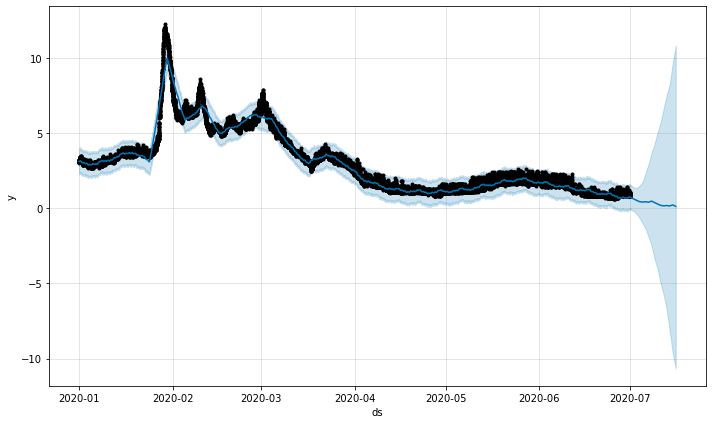

In [ ]:
        future = prophet_predictor.make_future_dataframe(periods=15)
        forecast = prophet_predictor.predict(future)
        print('Ajuste Prophet, intervalo de confianza del 95%')
        plot = prophet_predictor.plot(forecast)
        

In [ ]:
df_Arima

,Estimator,Horizon_Prediction,MAE,MAPE,MDAPE,MEDAE,MSE,RMSE,SMAPE


In [ ]:
forecast_steps_iter=forecast_steps_dict["15D"]

In [ ]:
y_arima = model_auto.predict(forecast_steps_iter,alpha=0.05)
       
future = prophet_predictor.make_future_dataframe(periods=forecast_steps_iter,freq='15min')
forecast=prophet_predictor.predict(future)
yhat,y_test = marshall_results_Prophet(forecast,test_turbidity)

y_ses = fitted_SES.forecast(forecast_steps_iter)

y_es=  fitted_model.forecast(forecast_steps_iter)

In [ ]:
plotting_results = pd.DataFrame(test_turbidity['116507_63680'][0:forecast_steps_iter]).copy()

In [ ]:
plotting_results.columns=['Test']
plotting_results['Autoarima'] = y_arima
plotting_results['Prophet'] = yhat[1:]
plotting_results['SES']=y_ses
plotting_results['ES']=y_es

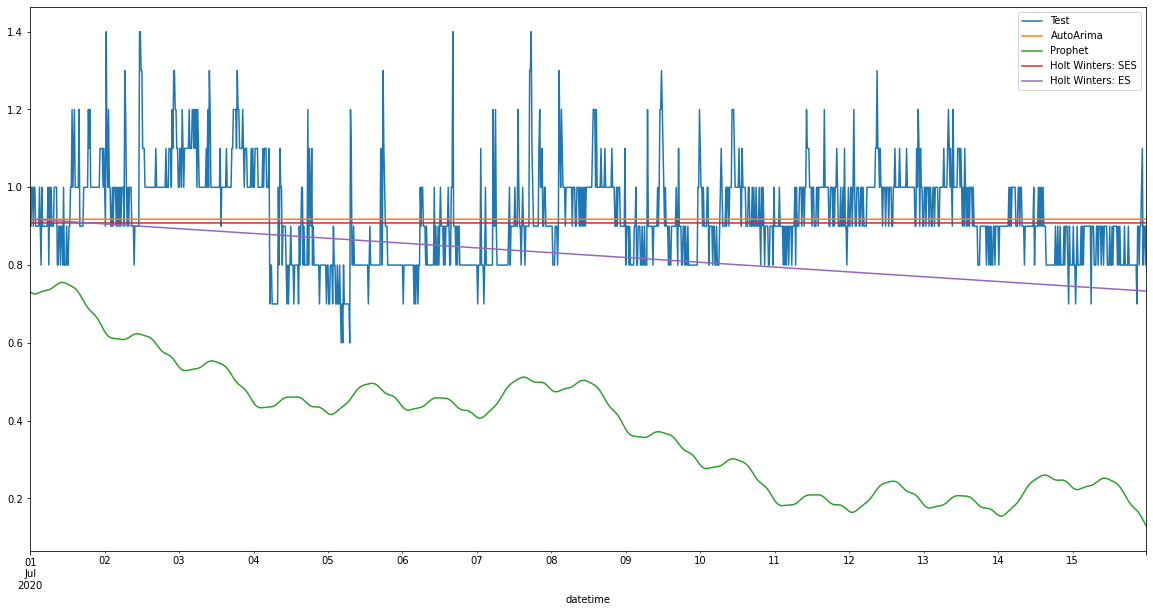

In [ ]:
plotting_results['Test'].plot(legend=True,label='Test',figsize=(20,10), set)
plotting_results['Autoarima'].plot(legend=True,label='AutoArima',figsize=(20,10))
plotting_results['Prophet'].plot(legend=True,label='Prophet',figsize=(20,10))
plotting_results['SES'].plot(legend=True,label='Holt Winters: SES',figsize=(20,10))
plotting_results['ES'].plot(legend=True,label='Holt Winters: ES',figsize=(20,10))

Esta claro que tampoco el intervalo de entrenamiento y test es una distribución normal...

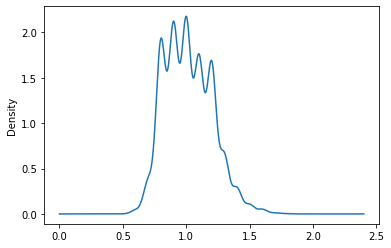

In [ ]:
test_turbidity['116507_63680'].plot(kind='kde')

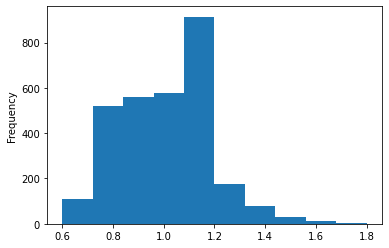

In [ ]:
test_turbidity['116507_63680'].plot(kind='hist')